# CGANs - Conditional Generative Adversarial Nets

Brief introduction to Conditional Generative Adversarial Nets or CGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training CGANs with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 3. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

* **Generator**: The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

* **Discriminator**: $x$ and $y$ are presented as inputs and to a discriminative function.

### Network Design

<img src="../../img/network_design_ccgan.png" width="600"> 


### Cost Funcion

$$ \underset{G}{min} \: \underset{D}{max} \; V_{CGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$


## 4. Training CGANs with MNIST dataset, Keras and TensorFlow

CGANs implementation using fully connected and embedding layers and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator are the **normal distribution** $z$ and $y$. They are combined in joint hidden representation.
        * Embedding($y, z$).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The input to the discriminator are $x$ and $y$. They are combined in joint hidden representation.
        *  Embedding($y, x$).
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

---
#### Embedding layer background

1/1 [==============================] - 0s 259ms/step
[[[ 0.04209062  0.04110918]
  [ 0.00218494 -0.00192791]
  [-0.03911266  0.01384952]
  [-0.02091298  0.00296807]
  [ 0.01764803  0.03845861]
  [ 0.00146054  0.02688267]
  [-0.01902294 -0.01390209]
  [-0.00482274 -0.02166729]
  [-0.00030088 -0.02781081]
  [-0.02653651 -0.02991054]]]


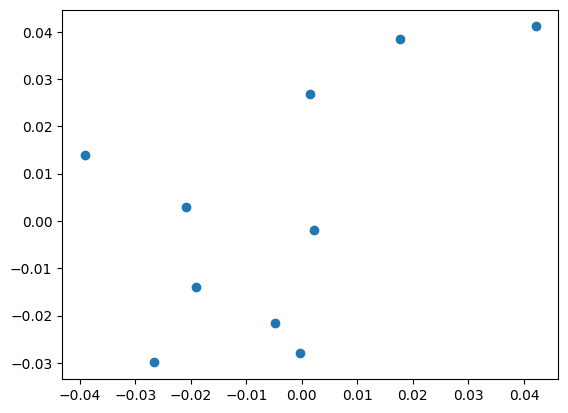

In [3]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

---
#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#### Explore visual data

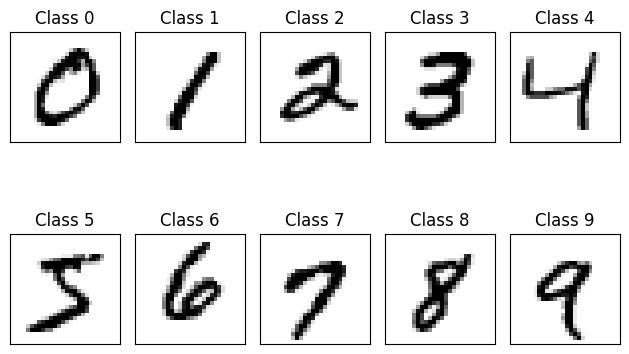

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray_r', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator

In [7]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [8]:
# prints a summary representation of your model
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                      

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

In [9]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

#### Conditional model visualization

In [10]:
# prints a summary representation of your model
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1000        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['embedding_1[0][0]']            
                                                                                              

#### Discriminator

In [11]:
# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


#### Discriminator model visualization

In [12]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

#### Conditional D model

$x$ and $y$ are presented as inputs

In [13]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

#### Conditional model visualization

In [14]:
# prints a summary representation of your model
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 784)       7840        ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['embedding_2[0][0]']            
                                                                                            

### 3. Compile model

#### Compile discriminator

In [20]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### Combined network

In [ ]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
# prints a summary representation of your model
d_g.summary()

### 4. Fit model


epoch = 1/100, d_loss=0.690, g_loss=0.916                                                                                                     
1/1 [==============================] - 0s 147ms/step


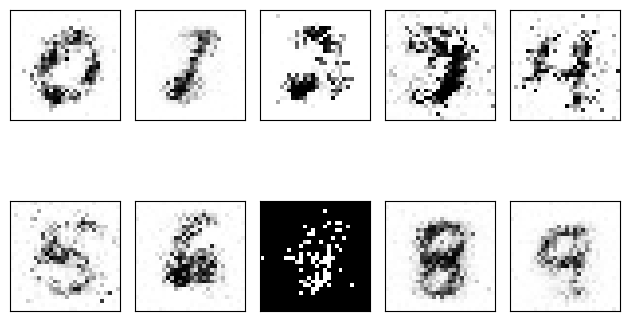

epoch = 2/100, d_loss=0.689, g_loss=0.845                                                                                                     
epoch = 3/100, d_loss=0.686, g_loss=0.834                                                                                                     
epoch = 4/100, d_loss=0.666, g_loss=0.810                                                                                                     
epoch = 5/100, d_loss=0.661, g_loss=0.841                                                                                                     
epoch = 6/100, d_loss=0.674, g_loss=0.817                                                                                                     
epoch = 7/100, d_loss=0.653, g_loss=0.867                                                                                                     
epoch = 8/100, d_loss=0.630, g_loss=0.843                                                                                                     

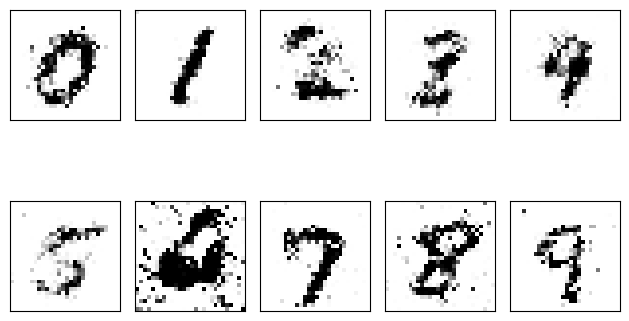

epoch = 12/100, d_loss=0.636, g_loss=0.834                                                                                                     
epoch = 13/100, d_loss=0.632, g_loss=0.835                                                                                                     
epoch = 14/100, d_loss=0.648, g_loss=0.866                                                                                                     
epoch = 15/100, d_loss=0.625, g_loss=0.954                                                                                                     
epoch = 16/100, d_loss=0.615, g_loss=0.934                                                                                                     
epoch = 17/100, d_loss=0.621, g_loss=0.952                                                                                                     
epoch = 18/100, d_loss=0.630, g_loss=0.903                                                                                              

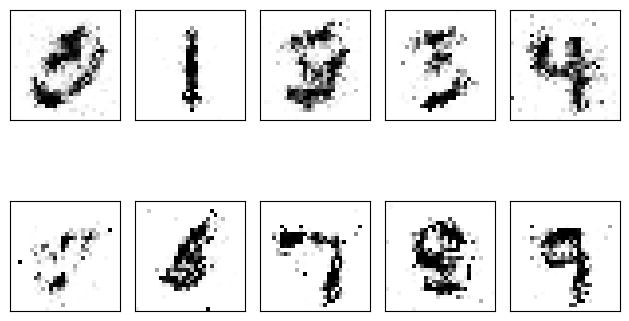

epoch = 22/100, d_loss=0.583, g_loss=0.937                                                                                                     
epoch = 23/100, d_loss=0.638, g_loss=0.958                                                                                                     
epoch = 24/100, d_loss=0.643, g_loss=0.921                                                                                                     
epoch = 25/100, d_loss=0.603, g_loss=0.964                                                                                                     
epoch = 26/100, d_loss=0.613, g_loss=0.949                                                                                                     
epoch = 27/100, d_loss=0.592, g_loss=0.943                                                                                                     
epoch = 28/100, d_loss=0.648, g_loss=0.916                                                                                              

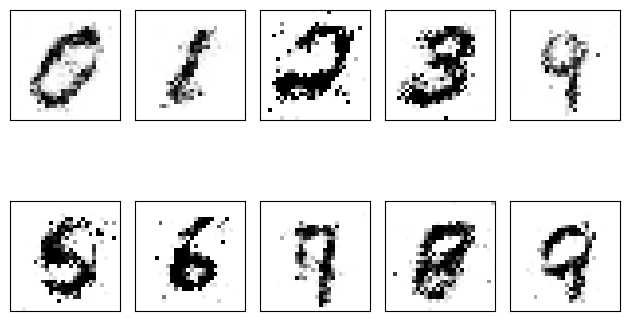

epoch = 32/100, d_loss=0.645, g_loss=0.906                                                                                                     
epoch = 33/100, d_loss=0.691, g_loss=0.875                                                                                                     
epoch = 34/100, d_loss=0.622, g_loss=0.876                                                                                                     
epoch = 35/100, d_loss=0.632, g_loss=0.895                                                                                                     
epoch = 36/100, d_loss=0.661, g_loss=0.854                                                                                                     
epoch = 37/100, d_loss=0.673, g_loss=0.885                                                                                                     
epoch = 38/100, d_loss=0.656, g_loss=0.915                                                                                              

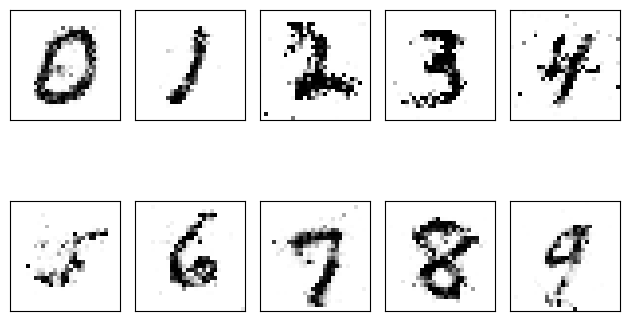

epoch = 42/100, d_loss=0.662, g_loss=0.880                                                                                                     
epoch = 43/100, d_loss=0.654, g_loss=0.841                                                                                                     
epoch = 44/100, d_loss=0.664, g_loss=0.882                                                                                                     
epoch = 45/100, d_loss=0.637, g_loss=0.885                                                                                                     
epoch = 46/100, d_loss=0.634, g_loss=0.898                                                                                                     
epoch = 47/100, d_loss=0.642, g_loss=0.877                                                                                                     
epoch = 48/100, d_loss=0.675, g_loss=0.927                                                                                              

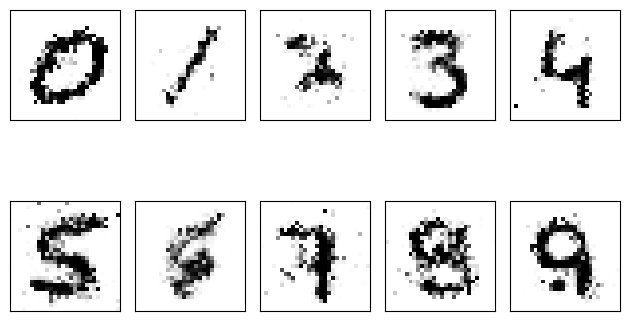

epoch = 52/100, d_loss=0.679, g_loss=0.880                                                                                                     
epoch = 53/100, d_loss=0.674, g_loss=0.879                                                                                                     
epoch = 54/100, d_loss=0.621, g_loss=0.873                                                                                                     
epoch = 55/100, d_loss=0.658, g_loss=0.852                                                                                                     
epoch = 56/100, d_loss=0.641, g_loss=0.877                                                                                                     
epoch = 57/100, d_loss=0.627, g_loss=0.886                                                                                                     
epoch = 58/100, d_loss=0.638, g_loss=0.822                                                                                              

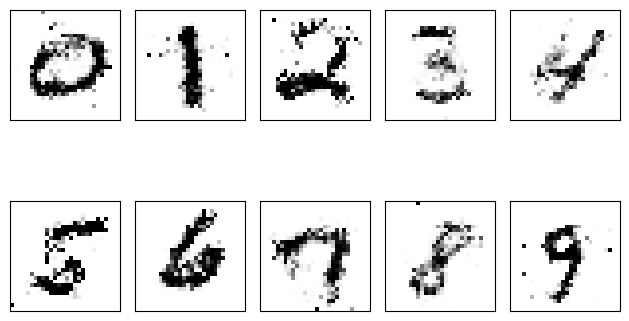

epoch = 62/100, d_loss=0.664, g_loss=0.936                                                                                                     
epoch = 63/100, d_loss=0.675, g_loss=0.895                                                                                                     
epoch = 64/100, d_loss=0.638, g_loss=0.891                                                                                                     
epoch = 65/100, d_loss=0.622, g_loss=0.850                                                                                                     
epoch = 66/100, d_loss=0.659, g_loss=0.865                                                                                                     
epoch = 67/100, d_loss=0.610, g_loss=0.889                                                                                                     
epoch = 68/100, d_loss=0.646, g_loss=0.865                                                                                              

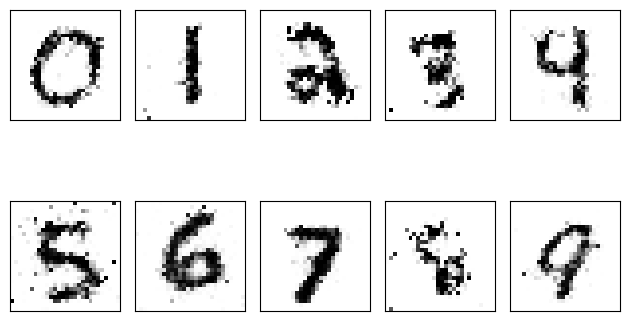

epoch = 72/100, d_loss=0.631, g_loss=0.874                                                                                                     
epoch = 73/100, d_loss=0.626, g_loss=0.884                                                                                                     
epoch = 74/100, d_loss=0.656, g_loss=0.875                                                                                                     
epoch = 75/100, d_loss=0.662, g_loss=0.827                                                                                                     
epoch = 76/100, d_loss=0.666, g_loss=0.838                                                                                                     
epoch = 77/100, d_loss=0.647, g_loss=0.877                                                                                                     
epoch = 78/100, d_loss=0.650, g_loss=0.892                                                                                              

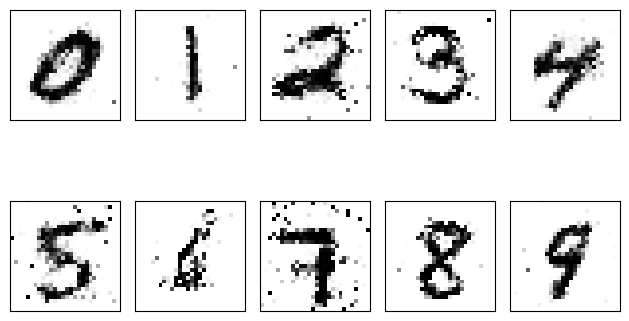

epoch = 82/100, d_loss=0.629, g_loss=0.845                                                                                                     
epoch = 83/100, d_loss=0.638, g_loss=0.853                                                                                                     
epoch = 84/100, d_loss=0.659, g_loss=0.884                                                                                                     
epoch = 85/100, d_loss=0.639, g_loss=0.879                                                                                                     
epoch = 86/100, d_loss=0.648, g_loss=0.877                                                                                                     
epoch = 87/100, d_loss=0.630, g_loss=0.881                                                                                                     
epoch = 88/100, d_loss=0.660, g_loss=0.897                                                                                              

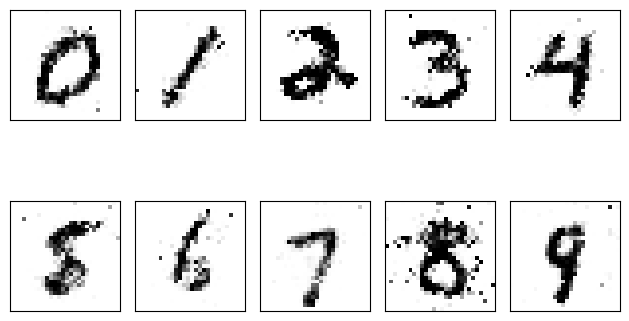

epoch = 92/100, d_loss=0.654, g_loss=0.910                                                                                                     
epoch = 93/100, d_loss=0.633, g_loss=0.887                                                                                                     
epoch = 94/100, d_loss=0.617, g_loss=0.862                                                                                                     
epoch = 95/100, d_loss=0.680, g_loss=0.883                                                                                                     
epoch = 96/100, d_loss=0.612, g_loss=0.912                                                                                                     
epoch = 97/100, d_loss=0.628, g_loss=0.924                                                                                                     
epoch = 98/100, d_loss=0.650, g_loss=0.856                                                                                              

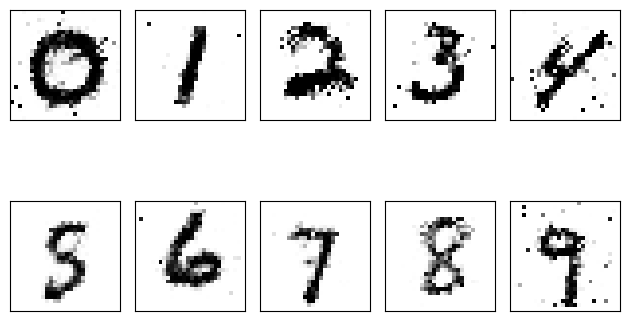

In [18]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray_r')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

In [24]:
X_train.shape

(60000, 784)

### 5. Evaluate model

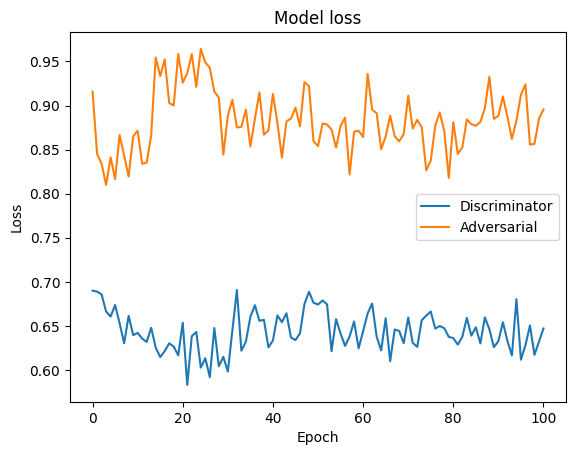

In [19]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()